In [1]:
import os
gpu_number = "0"
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_number

import tensorflow as tf
from tensorflow.keras import backend as keras_backend
import numpy as np

gpu_on = True

if gpu_on :
    gpu_devices = tf.config.experimental.list_physical_devices("GPU")
    for device in gpu_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    gpu_devices = tf.config.experimental.list_physical_devices("CPU")

print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import sys
from glob import glob
import numpy as np
sys.path.append("../../../../CNN_total/")

In [3]:
from src.data_loader.classification_video import ClassifyDataloader
from glob import glob

task = "classification"
data_set_name = "detect_lvi"
batch_size = 4
num_workers = 4
on_memory = False
augmentation_proba = 0.625
target_size = None
interpolation = "bilinear"
# class_mode = "binary"
class_mode = "categorical"
dtype="float32"

train_folder_list = glob(f"../data/2-2. Split png 64 frame/train/*/*")
valid_folder_list = glob(f"../data/2-2. Split png 64 frame/valid/*/*")
test_folder_list = glob(f"../data/2-2. Split png 64 frame/test/*/*")

label_list = os.listdir(f"../data/2. Split png/train")
label_level = 1

label_to_index_dict = {label:index for index, label in enumerate(label_list)}
index_to_label_dict = {index:label for index, label in enumerate(label_list)}

augmentation_policy_dict = {
    "positional": False,
    "noise": True,
    "elastic": False,
    "randomcrop": False,
    "brightness_contrast": False,
    "color": False,
    "to_jpeg": False
}

common_arg_dict = {
    "label_to_index_dict": label_to_index_dict,
    "label_level": label_level,
    "augmentation_policy_dict": augmentation_policy_dict,
    "preprocess_input": "-1~1",
    "target_size": target_size,
    "interpolation": interpolation,
    "class_mode": class_mode,
    "dtype": dtype
}

train_data_loader = ClassifyDataloader(image_folder_list=train_folder_list,
                                       batch_size=batch_size,
                                       num_workers=num_workers,
                                       on_memory=on_memory,
                                       augmentation_proba=augmentation_proba,
                                       shuffle=True,
                                       **common_arg_dict
)
valid_data_loader = ClassifyDataloader(image_folder_list=valid_folder_list,
                                       batch_size=batch_size,
                                       num_workers=1,
                                       on_memory=on_memory,
                                       augmentation_proba=0,
                                       shuffle=False,
                                       **common_arg_dict
)
test_data_loader = ClassifyDataloader(image_folder_list=test_folder_list,
                                       batch_size=1,
                                       num_workers=1,
                                       on_memory=False,
                                       augmentation_proba=0,
                                       shuffle=False,
                                       **common_arg_dict
)

Total data num 1276 with 11 classes
Total data num 76 with 11 classes
Total data num 50 with 11 classes


In [4]:
for i in range(5):
    data = train_data_loader[i]
    print(data[0].shape, data[1].shape)

print(np.min(data[0]), np.max(data[0]))
print(np.min(data[1]), np.max(data[1]))

for i in range(2):
    data = valid_data_loader[i]
    print(data[0].shape, data[1].shape)

print(np.min(data[0]), np.max(data[0]))
print(np.min(data[1]), np.max(data[1]))

(4, 64, 240, 320, 3) (4, 11)
(4, 64, 240, 320, 3) (4, 11)
(4, 64, 240, 320, 3) (4, 11)
(4, 64, 240, 320, 3) (4, 11)
(4, 64, 240, 320, 3) (4, 11)
-1.0 1.0
0.0 1.0
(4, 64, 240, 320, 3) (4, 11)
(4, 64, 240, 320, 3) (4, 11)
-1.0 1.0
0.0 1.0


In [5]:
from src.model.vision_transformer.classfication import get_swin_classification_3d

input_shape = (64, 240, 320, 3)
last_channel_num = 11
filter_num_begin = 64     # number of channels in the first downsampling block; it is also the number of embedded dimensions
depth = 3                  # the depth of SwinUNET; depth=4 means three down/upsampling levels and a bottom level 
stack_num_per_depth = 2         # number of Swin Transformers per downsampling level
patch_size = (4, 4, 4)        # Extract 4-by-4 patches from the input image. Height and width of the patch must be equal.
stride_mode = "same"
num_heads = [4, 8, 8, 8]   # number of attention heads per down/upsampling level
window_size = [4, 2, 2, 2] # the size of attention window per down/upsampling level
num_mlp = 128              # number of MLP nodes within the Transformer
act = "leakyrelu"
last_act = "softmax"
shift_window = True          # Apply window shifting, i.e., Swin-MSA
include_3d = True
swin_v2 = True
model = get_swin_classification_3d(input_shape, last_channel_num, 
                                  filter_num_begin, depth, stack_num_per_depth,
                                  patch_size, stride_mode, num_heads, window_size, num_mlp,
                                  act=act, last_act=last_act, shift_window=shift_window, 
                                   include_3d=include_3d, swin_v2=swin_v2)
print(f"model param num: {model.count_params()}")
print(f"model input shape: {model.input.shape}")
print(f"model output shape: {model.output.shape}")

C:\Users\gr300\anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


transformer output shape: (None, 9600, 128)
GAP shape: (None, 128)
model param num: 5849715
model input shape: (None, 64, 240, 320, 3)
model output shape: (None, 11)


In [6]:
from datetime import date

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.losses import CategoricalCrossentropy

today = date.today()

# YY/MM/dd
today_str = today.strftime("%Y-%m-%d")
today_weight_path = f"./result_daily/{task}/{data_set_name}/{today_str}/gpu_{gpu_number}/target_size_{target_size}/weights/" 
today_image_path = f"./result_daily/{task}/{data_set_name}/{today_str}/gpu_{gpu_number}/target_size_{target_size}/images/"
today_logs_path = f"./result_daily/{task}/{data_set_name}/{today_str}/gpu_{gpu_number}/target_size_{target_size}/"
os.makedirs(today_weight_path, exist_ok=True)
os.makedirs(today_logs_path, exist_ok=True)
optimizer = Nadam(1e-4, clipnorm=1)

save_c = ModelCheckpoint(
    today_weight_path+"/weights_{val_loss:.4f}_{loss:.4f}_{epoch:02d}.hdf5",
    monitor='val_loss',
    verbose=0,
    save_best_only=False,
    save_weights_only=True,
    mode='min')


def scheduler(epoch, lr):
    if epoch <= 40:
        new_lr = 2e-5
    elif epoch <= 100:
        new_lr = 2e-4
    elif epoch <= 200:
        new_lr = 2e-5
    else:
        new_lr = 2e-6
    return new_lr
scheduler_callback = LearningRateScheduler(scheduler, verbose=1)
csv_logger = CSVLogger(f'{today_logs_path}/log.csv', append=False, separator=',')
loss_function = CategoricalCrossentropy(label_smoothing=0.01)

model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

In [7]:
model.load_weights("./result_total/weights_1.3406_0.4472_107.hdf5")

In [ ]:
start_epoch = 107
epochs = 300

model.fit(
    train_data_loader,
    validation_data=valid_data_loader,
    epochs=epochs,
    callbacks=[scheduler_callback, save_c, csv_logger], 
    initial_epoch=start_epoch
)

Epoch 108/300

Epoch 00108: LearningRateScheduler setting learning rate to 2e-05.
319/319 [==============================] - 806s 2s/step - loss: 0.4395 - accuracy: 0.9067 - val_loss: 1.3396 - val_accuracy: 0.6053
Epoch 109/300

Epoch 00109: LearningRateScheduler setting learning rate to 2e-05.
319/319 [==============================] - 462s 1s/step - loss: 0.4176 - accuracy: 0.9114 - val_loss: 1.3688 - val_accuracy: 0.5921
Epoch 110/300

Epoch 00110: LearningRateScheduler setting learning rate to 2e-05.
319/319 [==============================] - 469s 1s/step - loss: 0.4407 - accuracy: 0.8997 - val_loss: 1.3382 - val_accuracy: 0.5789
Epoch 111/300

Epoch 00111: LearningRateScheduler setting learning rate to 2e-05.
319/319 [==============================] - 476s 1s/step - loss: 0.4257 - accuracy: 0.9208 - val_loss: 1.3327 - val_accuracy: 0.6184
Epoch 112/300

Epoch 00112: LearningRateScheduler setting learning rate to 2e-05.
319/319 [==============================] - 469s 1s/step - loss

In [10]:
start_epoch = 88
epochs = 300

model.fit(
    train_data_loader,
    validation_data=valid_data_loader,
    epochs=epochs,
    callbacks=[scheduler_callback, save_c, csv_logger], 
    initial_epoch=start_epoch
)

Epoch 89/300

Epoch 00089: LearningRateScheduler setting learning rate to 0.0002.
319/319 [==============================] - 553s 2s/step - loss: 0.8272 - accuracy: 0.7476 - val_loss: 1.5553 - val_accuracy: 0.5000
Epoch 90/300

Epoch 00090: LearningRateScheduler setting learning rate to 0.0002.
319/319 [==============================] - 459s 1s/step - loss: 0.8483 - accuracy: 0.7335 - val_loss: 1.6355 - val_accuracy: 0.5000
Epoch 91/300

Epoch 00091: LearningRateScheduler setting learning rate to 0.0002.
319/319 [==============================] - 452s 1s/step - loss: 0.7935 - accuracy: 0.7571 - val_loss: 1.9981 - val_accuracy: 0.3947
Epoch 92/300

Epoch 00092: LearningRateScheduler setting learning rate to 0.0002.
319/319 [==============================] - 463s 1s/step - loss: 0.8042 - accuracy: 0.7461 - val_loss: 1.7087 - val_accuracy: 0.5132
Epoch 93/300

Epoch 00093: LearningRateScheduler setting learning rate to 0.0002.
319/319 [==============================] - 465s 1s/step - loss

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\gr300\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-83c1c1245d39>", line 4, in <module>
    model.fit(
  File "C:\Users\gr300\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 1184, in fit
    tmp_logs = self.train_function(iterator)
  File "C:\Users\gr300\anaconda3\lib\site-packages\tensorflow\python\eager\def_function.py", line 885, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\gr300\anaconda3\lib\site-packages\tensorflow\python\eager\def_function.py", line 917, in _call
    return self._stateless_fn(*args, **kwds)  # pylint: disable=not-callable
  File "C:\Users\gr300\anaconda3\lib\site-packages\tensorflow\python\eager\function.py", line 3039, in __call__
    return graph_function._call_flat(
  File "C:\Users\gr300\anaconda3\lib\site-packages\tensorflow\python\eage

TypeError: object of type 'NoneType' has no len()

In [ ]:
start_epoch = 0
epochs = 300

model.fit(
    train_data_loader,
    validation_data=valid_data_loader,
    epochs=epochs,
    callbacks=[scheduler_callback, save_c, csv_logger], 
    initial_epoch=start_epoch
)

Epoch 1/300

Epoch 00001: LearningRateScheduler setting learning rate to 2e-05.
319/319 [==============================] - 907s 3s/step - loss: 2.4803 - accuracy: 0.1089 - val_loss: 2.4427 - val_accuracy: 0.1053
Epoch 2/300

Epoch 00002: LearningRateScheduler setting learning rate to 2e-05.
319/319 [==============================] - 489s 2s/step - loss: 2.3932 - accuracy: 0.1270 - val_loss: 2.3645 - val_accuracy: 0.1579
Epoch 3/300

Epoch 00003: LearningRateScheduler setting learning rate to 2e-05.
319/319 [==============================] - 463s 1s/step - loss: 2.3711 - accuracy: 0.1364 - val_loss: 2.3952 - val_accuracy: 0.1053
Epoch 4/300

Epoch 00004: LearningRateScheduler setting learning rate to 2e-05.
319/319 [==============================] - 448s 1s/step - loss: 2.3423 - accuracy: 0.1716 - val_loss: 2.4006 - val_accuracy: 0.1579
Epoch 5/300

Epoch 00005: LearningRateScheduler setting learning rate to 2e-05.
319/319 [==============================] - 463s 1s/step - loss: 2.3325 -

319/319 [==============================] - 496s 2s/step - loss: 1.0767 - accuracy: 0.6583 - val_loss: 1.5982 - val_accuracy: 0.4342
Epoch 78/300

Epoch 00078: LearningRateScheduler setting learning rate to 0.0002.
319/319 [==============================] - 504s 2s/step - loss: 1.0433 - accuracy: 0.6583 - val_loss: 1.6518 - val_accuracy: 0.4474
Epoch 79/300

Epoch 00079: LearningRateScheduler setting learning rate to 0.0002.
319/319 [==============================] - 497s 2s/step - loss: 1.0085 - accuracy: 0.6795 - val_loss: 1.8981 - val_accuracy: 0.3947
Epoch 80/300

Epoch 00080: LearningRateScheduler setting learning rate to 0.0002.
319/319 [==============================] - 483s 2s/step - loss: 1.0178 - accuracy: 0.6622 - val_loss: 1.6963 - val_accuracy: 0.4605
Epoch 81/300

Epoch 00081: LearningRateScheduler setting learning rate to 0.0002.
319/319 [==============================] - 474s 1s/step - loss: 0.9876 - accuracy: 0.6842 - val_loss: 1.6773 - val_accuracy: 0.4737
Epoch 82/300

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\gr300\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-910277f0d9c3>", line 4, in <module>
    model.fit(
  File "C:\Users\gr300\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 1184, in fit
    tmp_logs = self.train_function(iterator)
  File "C:\Users\gr300\anaconda3\lib\site-packages\tensorflow\python\eager\def_function.py", line 885, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\gr300\anaconda3\lib\site-packages\tensorflow\python\eager\def_function.py", line 917, in _call
    return self._stateless_fn(*args, **kwds)  # pylint: disable=not-callable
  File "C:\Users\gr300\anaconda3\lib\site-packages\tensorflow\python\eager\function.py", line 3039, in __call__
    return graph_function._call_flat(
  File "C:\Users\gr300\anaconda3\lib\site-packages\tensorflow\python\eager

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\gr300\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-910277f0d9c3>", line 4, in <module>
    model.fit(
  File "C:\Users\gr300\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 1184, in fit
    tmp_logs = self.train_function(iterator)
  File "C:\Users\gr300\anaconda3\lib\site-packages\tensorflow\python\eager\def_function.py", line 885, in __call__
    result = self._call(*args, **kwds)
  File "C:\Users\gr300\anaconda3\lib\site-packages\tensorflow\python\eager\def_function.py", line 917, in _call
    return self._stateless_fn(*args, **kwds)  # pylint: disable=not-callable
  File "C:\Users\gr300\anaconda3\lib\site-packages\tensorflow\python\eager\function.py", line 3039, in __call__
    return graph_function._call_flat(
  File "C:\Users\gr300\anaconda3\lib\site-packages\tensorflow\python\eager

In [12]:
start_epoch = 49
epochs = 300

model.fit(
    train_data_loader,
    validation_data=valid_data_loader,
    epochs=epochs,
    callbacks=[scheduler_callback, save_c, csv_logger], 
    initial_epoch=start_epoch
)

Epoch 50/300

Epoch 00050: LearningRateScheduler setting learning rate to 0.0002.
319/319 [==============================] - 454s 1s/step - loss: 2.0066 - accuracy: 0.3002 - val_loss: 1.8220 - val_accuracy: 0.3026
Epoch 51/300

Epoch 00051: LearningRateScheduler setting learning rate to 0.0002.
319/319 [==============================] - 447s 1s/step - loss: 1.8806 - accuracy: 0.3386 - val_loss: 2.0395 - val_accuracy: 0.3026
Epoch 52/300

Epoch 00052: LearningRateScheduler setting learning rate to 0.0002.
319/319 [==============================] - 448s 1s/step - loss: 1.8315 - accuracy: 0.3613 - val_loss: 1.7789 - val_accuracy: 0.3553
Epoch 53/300

Epoch 00053: LearningRateScheduler setting learning rate to 0.0002.
319/319 [==============================] - 449s 1s/step - loss: 1.7770 - accuracy: 0.3864 - val_loss: 1.8897 - val_accuracy: 0.2500
Epoch 54/300

Epoch 00054: LearningRateScheduler setting learning rate to 0.0002.
254/319 [======================>.......] - ETA: 1:29 - loss: 1

KeyboardInterrupt: 

In [8]:
start_epoch = 0
epochs = 300

model.fit(
    train_data_loader,
    validation_data=valid_data_loader,
    epochs=epochs,
    callbacks=[scheduler_callback, save_c, csv_logger], 
    initial_epoch=start_epoch
)

Epoch 1/300

Epoch 00001: LearningRateScheduler setting learning rate to 2e-05.
319/319 [==============================] - 791s 2s/step - loss: 2.4700 - accuracy: 0.1121 - val_loss: 2.4352 - val_accuracy: 0.0789
Epoch 2/300

Epoch 00002: LearningRateScheduler setting learning rate to 2e-05.
319/319 [==============================] - 488s 2s/step - loss: 2.3844 - accuracy: 0.1450 - val_loss: 2.3520 - val_accuracy: 0.1974
Epoch 3/300

Epoch 00003: LearningRateScheduler setting learning rate to 2e-05.
319/319 [==============================] - 435s 1s/step - loss: 2.3606 - accuracy: 0.1497 - val_loss: 2.3582 - val_accuracy: 0.1711
Epoch 4/300

Epoch 00004: LearningRateScheduler setting learning rate to 2e-05.
319/319 [==============================] - 441s 1s/step - loss: 2.3447 - accuracy: 0.1536 - val_loss: 2.2763 - val_accuracy: 0.2105
Epoch 5/300

Epoch 00005: LearningRateScheduler setting learning rate to 2e-05.
319/319 [==============================] - 446s 1s/step - loss: 2.3204 -

KeyboardInterrupt: 

In [7]:
model.load_weights("./weights_1.5013_0.5686_54.hdf5")

In [35]:
from src.data_loader.classification_video import ClassifyDataloader
from glob import glob

task = "classification"
data_set_name = "detect_lvi"
batch_size = 1
num_workers = 1
on_memory = False
augmentation_proba = 0.625
target_size = None
interpolation = "bilinear"
# class_mode = "binary"
class_mode = "categorical"
dtype="float32"

train_folder_list = glob(f"../data/2. Split png/train/*/*")
valid_folder_list = glob(f"../data/2. Split png/valid/*/*")
test_folder_list = glob(f"../data/2. Split png/test/*/*")

label_list = os.listdir(f"../data/2. Split png/train")
label_level = 1

label_to_index_dict = {label:index for index, label in enumerate(label_list)}
index_to_label_dict = {index:label for index, label in enumerate(label_list)}

augmentation_policy_dict = {
    "positional": False,
    "noise": True,
    "elastic": False,
    "randomcrop": False,
    "brightness_contrast": True,
    "color": False,
    "to_jpeg": False
}

common_arg_dict = {
    "label_to_index_dict": label_to_index_dict,
    "label_level": label_level,
    "augmentation_policy_dict": augmentation_policy_dict,
    "preprocess_input": "-1~1",
    "target_size": target_size,
    "interpolation": interpolation,
    "class_mode": class_mode,
    "dtype": dtype
}

train_data_loader = ClassifyDataloader(image_folder_list=train_folder_list,
                                       batch_size=batch_size,
                                       num_workers=num_workers,
                                       on_memory=on_memory,
                                       augmentation_proba=augmentation_proba,
                                       shuffle=False,
                                       **common_arg_dict
)
valid_data_loader = ClassifyDataloader(image_folder_list=valid_folder_list,
                                       batch_size=batch_size,
                                       num_workers=num_workers,
                                       on_memory=on_memory,
                                       augmentation_proba=0,
                                       shuffle=False,
                                       **common_arg_dict
)
test_data_loader = ClassifyDataloader(image_folder_list=test_folder_list,
                                       batch_size=1,
                                       num_workers=1,
                                       on_memory=False,
                                       augmentation_proba=0,
                                       shuffle=False,
                                       **common_arg_dict
)

Total data num 1276 with 11 classes
Total data num 76 with 11 classes
Total data num 50 with 11 classes


In [36]:
idx = 2
print(train_folder_list[idx])
x, y = train_data_loader[idx]

../data/2. Split png/train\BodyWeightSquats\v_BodyWeightSquats_g01_c03


[[9.9009490e-01 9.7977035e-02 7.6377107e-04 9.7597980e-01 5.7099175e-01
  2.1920732e-01 9.8332834e-01 2.8068927e-01 2.1960255e-05 7.8363264e-01
  9.8097897e-01]]


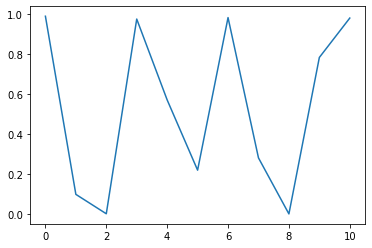

In [37]:
from matplotlib import pyplot as plt
print(model(x).numpy())
plt.plot(model(x).numpy()[0])

In [33]:
start_epoch = 0
epochs = 100

model.fit(
    train_data_loader,
    validation_data=valid_data_loader,
    epochs=epochs,
    callbacks=[reduceLROnPlat, save_c, csv_logger],
    initial_epoch=start_epoch
)

NameError: name 'reduceLROnPlat' is not defined